# Добавляем необходимые библиотеки:

In [1]:
pip install TensorFlow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from keras import layers
import logging
import numpy as np
import PIL.Image as Image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

CLASSIFIER_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5"
IMAGE_RES = 224

# Загружаем MobileNet-модель и создаём из неё Keras-модель
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])
model.summary()

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              4013897   
                                                                 
Total params: 4,013,897
Trainable params: 0
Non-trainable params: 4,013,897
_________________________________________________________________


# Генерируем обучающие и тестовую выборки:

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,     # масштабирование значений пикселей
    shear_range=0.2,    # сдвиг изображения вдоль оси X
    zoom_range=0.2,     # масштабирование изображения
    rotation_range=10,  # поворот изображения на угол в градусах
    brightness_range=[0.5, 1.5],  # изменение яркости изображения
    horizontal_flip=False, # переворот изображения относительно горизонтальной оси
    vertical_flip=False)  # переворот изображения относительно вертикальной оси  

train_set = train_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-train',   # путь к папке с обучающими изображениями
    target_size=(IMAGE_RES, IMAGE_RES),    # размер изображений
    batch_size=32,             # размер пакета (batch)
    class_mode='categorical')       # тип меток (binary или categorical)

Found 19256 images belonging to 193 classes.


In [4]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-validation',
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=32,
    class_mode='categorical')

Found 446 images belonging to 193 classes.


# Загружаем модель:

In [5]:
from math import ceil

STEPS_PER_EPOCH = ceil(len(train_set.filenames) / 128)

# Использование learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*10,
  decay_rate=1,
  staircase=False)

In [6]:
fe_link = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5'
feature_extractor = hub.KerasLayer(fe_link, input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        layers.BatchNormalization(),
        layers.Dense(193, activation='softmax'),
        # layers.Dropout(0.2)
      ])

model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2731616   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 193)               247233    
                                                                 
Total params: 2,983,969
Trainable params: 249,793
Non-trainable params: 2,734,176
_________________________________________________________________


# Настраиваем обучение:

In [8]:
from keras.callbacks import EarlyStopping

early_stop =  EarlyStopping(
                              patience=10,
                              min_delta=0.001,                               
                              monitor="val_loss",
                              restore_best_weights=True
                              )


EPOCHS = 100

history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=validation_set, 
                    callbacks=[early_stop])

from tensorflow.keras.models import load_model

model.save_weights('Diplom-BN.h5')

Epoch 1/100
602/602 [==============================] - 882s 1s/step - loss: 0.2980 - accuracy: 0.9535 - val_loss: 1.5710 - val_accuracy: 0.6906
Epoch 2/100
602/602 [==============================] - 792s 1s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.4885 - val_accuracy: 0.7063
Epoch 3/100
602/602 [==============================] - 799s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.4394 - val_accuracy: 0.7220
Epoch 4/100
602/602 [==============================] - 813s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.4030 - val_accuracy: 0.7265
Epoch 5/100
602/602 [==============================] - 766s 1s/step - loss: 9.6898e-04 - accuracy: 1.0000 - val_loss: 1.3864 - val_accuracy: 0.7287
Epoch 6/100
602/602 [==============================] - 707s 1s/step - loss: 6.5021e-04 - accuracy: 1.0000 - val_loss: 1.3690 - val_accuracy: 0.7354
Epoch 7/100
602/602 [==============================] - 733s 1s/step - loss: 5.3241e-04 - accuracy: 1.0000 - val_loss: 1.3509 - v

In [9]:
# model.load_weights('diplom-2.h5')

# Графическое отображение результатов:

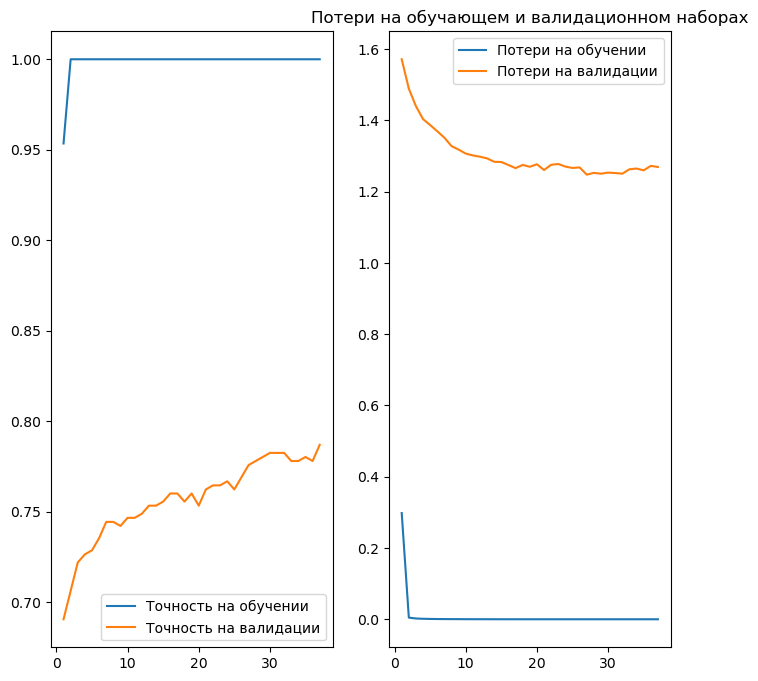

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающем и валидационном наборах')
plt.show()

In [11]:
def data_generator(dataset, batch_size):
  i = 0
  while True:
    batch = dataset[i:i+batch_size]
    if not len(batch):
      break
    yield batch
    i += batch_size

batch_size = 10
val_data = data_generator(validation_set, batch_size)

In [12]:
class_names = np.array(list(validation_set.class_indices.keys()))

val_data = iter(validation_set)
image_batch, label_batch = next(val_data)

In [13]:
print('label_batch shape:', np.shape(label_batch))

label_batch shape: (32, 193)


In [14]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['084 - Финодири', '059 - Атекар', '011 - Килсус', '078 - Снаг',
       '033 - Выброс силы', '133 - Ратэал', '029 - Шипящий дракон',
       '135 - Собиратель душ', '066 - Исила', '169 - Чёрный фолиант',
       '102 - Паства Архааля', '127 - Надих', '043 - Лекарь клана Камня',
       '004 - Дракон Хаоса', '057 - Уставший гном', '037 - Гном-рекрут',
       '119 - Аш', '135 - Собиратель душ', '129 - Осквернить',
       '089 - Врата Ихвэ', '076 - Серк', '190 - Сахана',
       '055 - Спящий дракон', '170 - Чистильщик катакомб', '027 - Циррея',
       '075 - Пурш', '129 - Осквернить', '014 - Объезженный дракон',
       '029 - Шипящий дракон', '049 - Пророчество', '188 - Дион',
       '090 - Гвург'], dtype='<U25')

In [15]:
# преобразование матрицы предсказаний
predicted_ids = tf.one_hot(predicted_ids, 193)

In [16]:
# проверка размера матриц
print("Метки: ", label_batch.shape)
print("Предсказания: ", predicted_ids.shape)

Метки:  (32, 193)
Предсказания:  (32, 193)


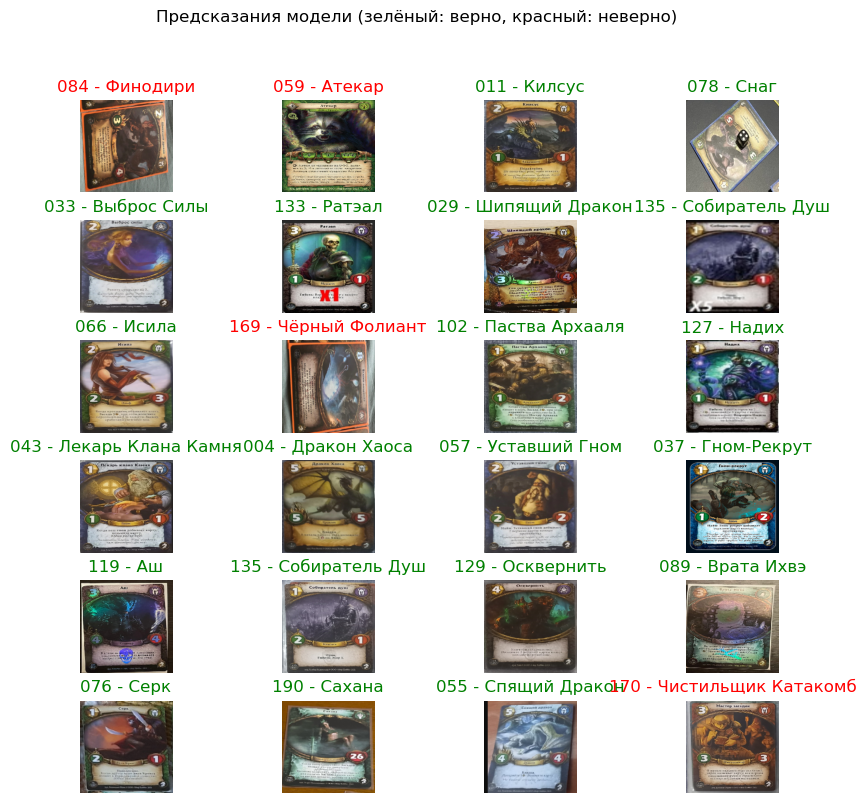

In [17]:
plt.figure(figsize=(10, 9))
for n in range(24):
  plt.subplot(6, 4, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = "green" if np.array_equal(predicted_ids[n], label_batch[n]) else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Предсказания модели (зелёный: верно, красный: неверно)")

In [20]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to csv: 
history_csv = 'Diplom-BN-History.csv'
with open(history_csv, mode='w') as f:
    hist_df.to_csv(f)

In [23]:
pd.read_csv('Diplom-BN-History.csv')

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.298026,0.953469,1.570979,0.690583
1,1,0.004675,1.000000,1.488527,0.706278
2,2,0.002215,1.000000,1.439404,0.721973
3,3,0.001405,1.000000,1.403030,0.726457
4,4,0.000969,1.000000,1.386423,0.728700
5,5,0.000650,1.000000,1.368985,0.735426
6,6,0.000532,1.000000,1.350912,0.744395
7,7,0.000454,1.000000,1.327436,0.744395
8,8,0.000355,1.000000,1.317585,0.742152
9,9,0.000244,1.000000,1.306414,0.746637
